<a href="https://colab.research.google.com/github/mostafa-ja/sample/blob/master/PyTorch_Tutorial_15_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Link of tutorial ](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

[Link of explaining fiest part of codes(Python_Dictionary_Comprehensio)](https://github.com/mostafa-ja/sample/blob/master/Python_Dictionary_Comprehension.ipynb)

[Link of video in youtube](https://www.youtube.com/watch?v=K0lWSB2QoIQ&list=PLqnslRFeH2UrcDBWF5mfPGpqQDSta6VK4&index=15)


In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

# `Load Data

The problem we’re going to solve today is to train a model to classify ants and bees. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

In [2]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip

--2022-08-12 14:29:47--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.65.229.70, 18.65.229.105, 18.65.229.67, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.65.229.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip.1’

hymenoptera_data.zi 100%[===================>]  45.10M   164MB/s    in 0.3s    

2022-08-12 14:29:48 (164 MB/s) - ‘hymenoptera_data.zip.1’ saved [47286322/47286322]



In [3]:
import zipfile
with zipfile.ZipFile('/content/hymenoptera_data.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

In [5]:
data_transform = {'train':transforms.Compose([transforms.RandomResizedCrop(224),
                                              transforms.RandomHorizontalFlip(),
                                              transforms.ToTensor(),
                                              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
                  'val':transforms.Compose([transforms.Resize(256),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])}
                                            

In [33]:
data_dir = '/content/hymenoptera_data'

image_dataset = {x: datasets.ImageFolder(os.path.join(data_dir,x), data_transform[x]) for x in ['train','val'] }

dataloader = {x: torch.utils.data.DataLoader(image_dataset[x], batch_size=4, shuffle=True, num_workers=2) for x in ['train','val']}

data_size = {x: len(image_dataset[x]) for x in ['train','val']}

class_names = image_dataset['train'].classes

In [12]:
image_dataset['train'].classes

['ants', 'bees']

# Visualize a few images

In [16]:
def imshow(inp):
  inp = inp.numpy().transpose([1,2,0])
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp,0,1) # put all data inside [0,1)
  plt.imshow(inp)

In [23]:
# Get a batch of training data
images , classes = next(iter(dataloader['train'])) # torch.Size([4, 3, 224, 224])

# Make a grid from batch
out = torchvision.utils.make_grid(images)  # torch.Size([3, 228, 906])

# torchvision.utils.make_grid() returns a tensor containing grid of images. here batch_size is 4 , so it Connects four pictures together
# convert [4, 3, 224, 224]  into [3, 228, 906] means that connect 4 pictures on the third dimension

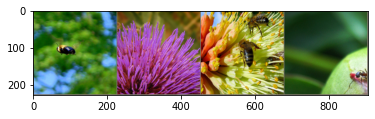

In [24]:
imshow(out)

# Training the mode

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
  since = time.time()

  best_model = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs-1} ')
    print('_' * 10)
    
    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
      if phase == 'train' :
        model.train()
      else:
        model.eval()
      
      running_loss = 0.0
      running_corrects = 0

      # Iterate over data.
      for inputs,labels in dataloader(phase):

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history if only in train
        with torch.set_grad_enabled(phase=='train'):
          outputs = model(inputs)
          _,preds = torch.max(outputs,1)
          loss = criterion(outputs,labels)

           # backward + optimize only if in training phase
           if phase == 'train':
             loss.backward()
             optimizer.step()

        # statistics
        running_loss += loss.item() * input.size() 
        running_corrects += torch.sum(preds == labels.data)  # labels.data ??? or labels.detach()

        if phase == 'train':
          scheduler.step()
        
        epoch_loss = running_loss / data_size[phase]
        epoch_acc = running_corrects.duble() / data_size[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())


  time_elapsed = time.time() - since
  print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
  print(f'Best val Acc: {best_acc:4f}')

  # load best model weights
  model.load_state_dict(best_model_wts)
  return model




no difference between with torch.no_grad()  & with torch.set_grad_enabled(False)


there is an additional functionality of torch.set_grad_enabled over torch.no_grad when used in a with-statement which lets you control to switch on or off gradient computation
